In [13]:
%matplotlib inline
import scipy.io
import numpy as np
import pandas as pd
from pathlib import Path
import re
from collections import Counter
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data import TensorDataset
import torch.utils.data as data
from torchvision import datasets
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # use gpu

In [2]:
def import_depth_data(action, subject, trial):
    filename = f'../Data/UTDMHAD_data/Depth/a{action}_s{subject}_t{trial}_depth.mat'# The name of the .mat files
    if Path(filename).is_file():
        mat = scipy.io.loadmat(filename)
        return mat['d_depth']
    else:
        return None

def transform_depth_data(action, subject, trial):
    rows = []
    data = import_depth_data(action, subject, trial)
    if data is None: return None
    for frame in range(data.shape[2]):
        pixels = data[:, :, frame].flatten()
        rows.append(pixels)
    result = np.insert(rows, 0, [[action], [subject], [trial], [frame]], axis=1)
    return np.array(result)

def transform_depth_data_to_df(action, subject, trial):
    data = transform_depth_data(action, subject, trial)
    if data is None: return None
    df = pd.DataFrame(data)
    df.columns = ['action', 'subject', 'trial', 'frame'] + [f'depth_{n}' for n in range(240 * 320)]
    return df

def export_depth_data_to_csv(action, subject, trial):
    df = transform_depth_data_to_df(action, subject, trial)
    if df is None: return None
    filename = f'a{action}_s{subject}_t{trial}_depth.csv'
    df.to_csv(filename, index=False)

def show_depth_image(action, subject, trial, frame):
    data = import_depth_data(action, subject, trial)
    if data is None: return None
    plt.imshow(data[:,:,frame], cmap='gray')
    plt.axis('off')
    plt.show()

In [3]:
def import_inertial_data(action, subject, trial):
    filename = f'../Data/UTDMHAD_data/Inertial/a{action}_s{subject}_t{trial}_inertial.mat'
    if Path(filename).is_file():
        mat = scipy.io.loadmat(filename)
        return mat['d_iner']
    else:
        return None
    
def transform_inertial_data(action, subject, trial):
    data = import_inertial_data(action, subject, trial)
    if data is None: return None
    result = np.insert(data, 0, [[action], [subject], [trial]], axis=1)
    return np.array(result)

def transform_inertial_data_to_df(action, subject, trial):
    data = transform_inertial_data(action, subject, trial)
    if data is None: return None
    df = pd.DataFrame(data)
    df.columns = ['action', 'subject', 'trial', 'x-accel', 'y-accel', 'z-accel', 'x-ang-accel', 'y-ang-accel', 'z-ang-accel']
    return df

In [4]:
activities = [i for i in range(1,28)]
raw_dataframe = transform_inertial_data_to_df(0, 0, 0)
for index, action in enumerate(activities):
    for subject in range(1, 9):
        for trial in range(1, 5):
            data = transform_inertial_data_to_df(action, subject, trial) # (160, 6)
            if data is None: continue
            #data = data[0:128] #(128.6) # maximum length is 128
            raw_dataframe = pd.concat([raw_dataframe, data])
raw_dataframe

,action,subject,trial,x-accel,y-accel,z-accel,x-ang-accel,y-ang-accel,z-ang-accel
0,1.0,1.0,1.0,-0.959473,-0.177734,-0.192871,5.221374,1.526718,0.152672
1,1.0,1.0,1.0,-0.961914,-0.153320,-0.159912,6.778626,1.954198,0.244275
2,1.0,1.0,1.0,-0.974609,-0.152832,-0.145996,11.267176,3.175573,1.099237
3,1.0,1.0,1.0,-0.941895,-0.135742,-0.127930,16.885496,4.732824,2.320611
4,1.0,1.0,1.0,-0.958252,-0.201416,-0.139404,16.030534,4.000000,0.366412
...,...,...,...,...,...,...,...,...,...
250,27.0,8.0,3.0,-0.908936,0.045410,0.541992,-1.801527,0.427481,0.000000
251,27.0,8.0,3.0,-0.909668,0.055176,0.532471,-2.076336,0.335878,0.244275
252,27.0,8.0,3.0,-0.916748,0.050781,0.528320,-1.954198,0.396947,0.305344
253,27.0,8.0,3.0,-0.915039,0.041260,0.534424,-1.648855,0.244275,0.213740


In [5]:
# window_size: size of time window
# step: overlapping
# data: dataset
def time_windows(window_size,overlapping,data):
  sigmentation_data_temp = []
  sigmentation_data = []
  sigmentation_label = []
  for i in range(0,len(data),overlapping):
    acc_x = data['x-accel'].values[i:i+window_size]
    acc_y = data['y-accel'].values[i:i+window_size]
    acc_z = data['z-accel'].values[i:i+window_size]
    gyro_x = data['x-ang-accel'].values[i:i+window_size]
    gyro_y = data['y-ang-accel'].values[i:i+window_size]
    gyro_z = data['z-ang-accel'].values[i:i+window_size]
    total_label = data['action'].values[i:i+window_size]
    label = Counter(total_label).most_common()[0][0]
    sigmentation_data_temp.append([acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z])
    sigmentation_arr = np.asarray(sigmentation_data_temp)
    sig_size = sigmentation_arr.shape
    if sig_size[2] == window_size:
      sigmentation_arr.reshape(window_size,6)
      sigmentation_data.append(sigmentation_arr)
      sigmentation_label.append(label)
      sigmentation_data_temp = []
    else:
      sigmentation_data_temp = []

  sigmentation_data_arr = np.asarray(sigmentation_data)
  sigmentation_label_arr = np.asarray(sigmentation_label)

  return sigmentation_data_arr,sigmentation_label_arr

In [6]:
utd_readings,utd_labels = time_windows(128,64,raw_dataframe)

In [119]:
print('Shape of data:')
print(utd_readings.shape)
print('Shape of label')
utd_labels.shape

Shape of data:
(2430, 1, 6, 128)
Shape of label


(2430,)

In [7]:
utd_labels -= 1

In [51]:
utd_labels

array([ 0.,  0.,  0., ..., 26., 26., 26.])

In [21]:
#split the dataset 
idx_list = np.array(range(2430))
np.random.shuffle(idx_list)
train_idxes = idx_list[:2000]
test_idxes = idx_list[2000:]
train_features = utd_readings[train_idxes]
train_labels = utd_labels[train_idxes]
test_features = utd_readings[test_idxes]
test_labels = utd_labels[test_idxes]
# train_features = np.array([utd_readings[i] for i in train_idxes])
# train_labels = np.array([utd_labels[i] for i in train_idxes])

# test_features = np.array([utd_readings[i] for i in test_idxes])
# test_labels = np.array([utd_labels[i] for i in test_idxes])
# train_features, train_labels = utd_readings, utd_labels
# test_features, test_labels = utd_readings, utd_labels

In [29]:
np.array(train_labels)

array([15.,  1.,  2., ..., 15., 18., 20.])

In [22]:
train_dataset = TensorDataset(torch.from_numpy(train_features).to(torch.float32),torch.from_numpy(train_labels).to(torch.float32))

test_dataset = TensorDataset(torch.from_numpy(test_features).to(torch.float32),torch.from_numpy(test_labels).to(torch.float32))


In [23]:
train_loader = data.DataLoader(dataset = train_dataset,batch_size = 64,shuffle = True)

test_loader = data.DataLoader(dataset = test_dataset,batch_size = 64,shuffle = False)

In [24]:
class CNN_UTD(nn.Module):
  def __init__(self):
    super(CNN_UTD, self).__init__()
    self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2, stride=2))
    self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2,2))
    self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=2),
            nn.ReLU()
    )
    # self.drop_out = nn.Dropout()
    self.fc1 = nn.Linear(6336, 512)
    self.fc3 = nn.Linear(512,27)
  def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        # out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc3(out)
        return out
        
model = CNN_UTD().to(device)

In [25]:
epoches = 50
lr = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=lr, weight_decay=0.0001,momentum = 0.8)

In [26]:
# training
loss_list = []
for epoch in range(epoches):
    acc = 0
    correct = 0
    total = 0
    loss_num = 0
    runtime_loss = 0
    for (imgs,labels) in train_loader:
        imgs = imgs.reshape(len(imgs),1,32,24)     
        imgs = imgs.to(device)
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        runtime_loss += loss.item()
        loss.backward()
        optimizer.step()
        total += labels.size(0)
        _,predicted = torch.max(outputs.data,1)
        correct += (predicted == labels).sum().item()
        loss_num+=1
    acc = 100 * correct / total
    epoch_loss = runtime_loss / loss_num
    loss_list.append(epoch_loss)
    loss_num = 0
    print("Epoch: ",epoch+1, "accuracy: ", acc,' %',"Loss: ",epoch_loss)

Epoch:  1 accuracy:  13.8  % Loss:  2.9845623672008514
Epoch:  2 accuracy:  39.0  % Loss:  2.069436427205801
Epoch:  3 accuracy:  52.15  % Loss:  1.579998154193163
Epoch:  4 accuracy:  61.9  % Loss:  1.1950456574559212
Epoch:  5 accuracy:  69.45  % Loss:  0.9560904819518328
Epoch:  6 accuracy:  75.75  % Loss:  0.7742084767669439
Epoch:  7 accuracy:  79.75  % Loss:  0.6823347173631191
Epoch:  8 accuracy:  84.55  % Loss:  0.5271679991856217
Epoch:  9 accuracy:  86.45  % Loss:  0.4722176529467106
Epoch:  10 accuracy:  88.85  % Loss:  0.3797886432148516
Epoch:  11 accuracy:  91.2  % Loss:  0.3123303120955825
Epoch:  12 accuracy:  94.7  % Loss:  0.22243187832646072
Epoch:  13 accuracy:  93.95  % Loss:  0.20395065331831574
Epoch:  14 accuracy:  96.0  % Loss:  0.1511175218038261
Epoch:  15 accuracy:  96.8  % Loss:  0.13808455830439925
Epoch:  16 accuracy:  96.95  % Loss:  0.12021964020095766
Epoch:  17 accuracy:  98.65  % Loss:  0.0883406843058765
Epoch:  18 accuracy:  98.65  % Loss:  0.08517

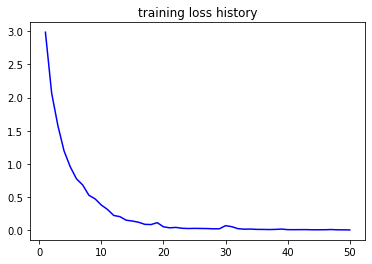

In [28]:
import matplotlib.pyplot as plt
x = []
for i in range(1,51):
  x.append(i)
y = loss_list
fig = plt.figure()
plt.plot(x,y,color = 'blue')
plt.title('training loss history')
plt.show()

In [29]:
# test
correct_test = 0

total_test = 0

with torch.no_grad():

  for (imgs_test,labels_test) in test_loader:

    imgs_test = imgs_test.reshape(len(imgs_test),1,32,24)

    imgs_test = imgs_test.to(device)

    labels_test = labels_test.type(torch.LongTensor)

    labels_test = labels_test.to(device)

    outputs_test = model(imgs_test)

    labels_test = labels_test.reshape(labels_test.shape[0],)

    predicted_test = torch.max(outputs_test.data,1)[1]
      
    total_test += labels_test.size(0)
      
    correct_test += (predicted_test == labels_test).sum().item()

    test_accuracy = 100*correct_test/total_test

print('validation accuracy is: ',test_accuracy)

validation accuracy is:  65.34883720930233
